<a href="https://colab.research.google.com/github/Rohitjadhav7174/Collaborative-Filtering-for-Movie-Recommendations/blob/main/collaboration_filtering_on_new_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 15.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile

import keras
from keras import layers
from keras import ops

In [15]:
df=pd.read_csv("/content/Netflix_Dataset_Rating.csv")
df.head(5)

,userId,movieId,rating
0,6,30,3
1,6,173,4
2,6,175,5
3,6,191,2
4,6,197,3


In [16]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 142417, Number of Movies: 91, Min rating: 1.0, Max rating: 5.0


In [17]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [18]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = ops.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return ops.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

In [19]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 971s 131ms/step - loss: 0.6415 - val_loss: 0.6399
Epoch 2/5
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 939s 127ms/step - loss: 0.6469 - val_loss: 0.6341
Epoch 3/5
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 858s 116ms/step - loss: 0.6275 - val_loss: 0.6276
Epoch 4/5
7373/7373 ━━━━━━━━━━━━━━━━━━━━ 948s 128ms/step - loss: 0.6177 - val_loss: 0.6253
Epoch 5/5
1659/7373 ━━━━━━━━━━━━━━━━━━━━ 10:34 111ms/step - loss: 0.6144

KeyboardInterrupt: 

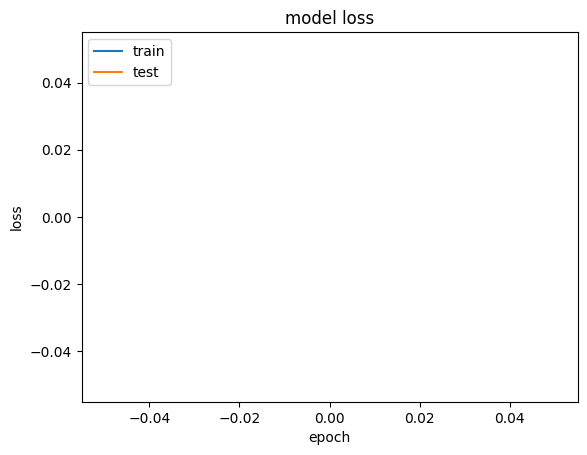

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
